In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path

In [3]:
ROOT_PATH = Path("/content/drive/MyDrive/blog/PyTorch_using_transformers")
DATA_PATH = ROOT_PATH / "datasets"
SAVE_PATH = ROOT_PATH / "03_파이토치 기초/save"
os.makedirs(SAVE_PATH, exist_ok=True)

# 활성화 함수

## 시그모이드 함수

In [7]:
def sigmoid(a, x):
  return 1 / (1 + np.exp(-a*x))

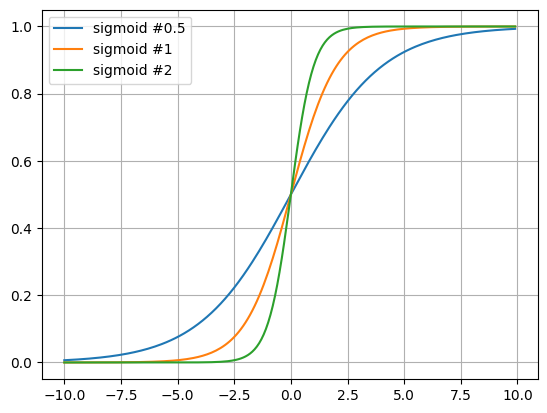

In [8]:
x = np.arange(-10, 10, 0.1)
for a in [0.5, 1, 2]:
  y = sigmoid(a, x)
  plt.plot(x, y, label=f'sigmoid #{a}')
  plt.legend()
  plt.grid()
plt.savefig(SAVE_PATH / 'sigmoid.png')

## BCE

In [9]:
def BCE_1(y, yhat):
  return -(y*np.log(yhat))

def BCE_0(y, yhat):
  return -(1-y)*np.log(1-yhat)

def BCE(y, yhat):
  return BCE_1(y, yhat) + BCE_0(y, yhat)

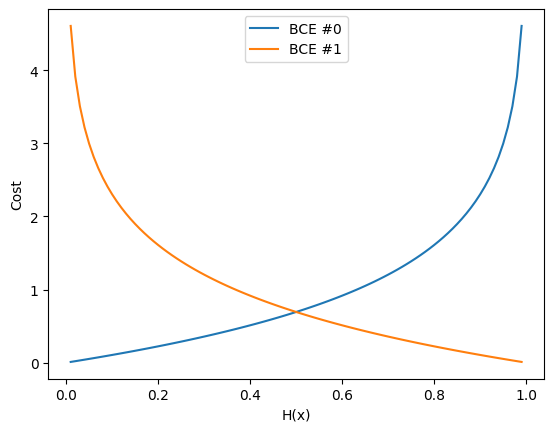

In [10]:
yhat = np.arange(0.01, 1, 0.01)
for y in [0, 1]:
  plt.plot(yhat, BCE(y, yhat), label=f'BCE #{y}')
  plt.legend()
  plt.grid()
plt.xlabel('H(x)')
plt.ylabel('Cost')
plt.savefig(SAVE_PATH / 'BCE.png')

## 이진분류: 파이토치

In [11]:
pd.read_csv(DATA_PATH / "binary.csv")

,x,y,z,pass
0,86,22,1,False
1,81,75,91,True
2,54,85,78,True
3,5,58,4,False
4,53,93,100,True
...,...,...,...,...
995,38,30,83,False
996,73,78,85,True
997,52,50,29,False
998,60,66,16,False


### 사용자 정의 데이터세트

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, file_path):
    df = pd.read_csv(file_path)
    self.x1 = df.iloc[:, 0].values
    self.x2 = df.iloc[:, 1].values
    self.x3 = df.iloc[:, 2].values
    self.y = df.iloc[:, 3].values
    self.lenght = len(df)

  def __getitem__(self, index):
    x = torch.tensor([self.x1[index], self.x2[index], self.x3[index]], dtype=torch.float)
    y = torch.tensor([self.y[index], dtype=torch.float])
    return x, y

  def __len__(self):
    return self.length

### 사용자 정의 모델

In [ ]:
class CustomModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = torch.nn.Sequential(
        torch.nn.Linear(3, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    x = self.layer(x)
    return x

### 이진 분류

In [ ]:
dataset = CustomDataset(DATA_PATH / "binary.csv")
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size], torch.manual_seed(4))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomModel().to(device)
criterion = nn.BCELoss().to(device) # 이진 교차 엔트로피
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(10000):
  cost = 0.0

  for x, y in train_dataloader:
    x = x.to(device)
    y = y.to(device)

    output = model(x)
    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    cost += loss

  cost = cost / len(train_dataloader)

  if (epoch + 1) % 1000 == 0:
    print(f"Epoch : {epoch+1:4d}, Model : {list(model.parameters())}, Cost : {cost:.3f}")

In [ ]:
with torch.no_grad():
  model.eval()
  for x, y in validation_dataloader:
    x = x.to(device)
    y = y.to(device)

    outputs = model(x)

    print(outputs)
    print(outputs >= torch.FloatTensor([0.5]).to(device))
    print("--------------------")

## 비선형 활성화 함수

### 계단 함수

In [18]:
def step_function(x):
  y = x.copy()
  y[y >= 0] = 1
  y[y < 0] = 0
  return y

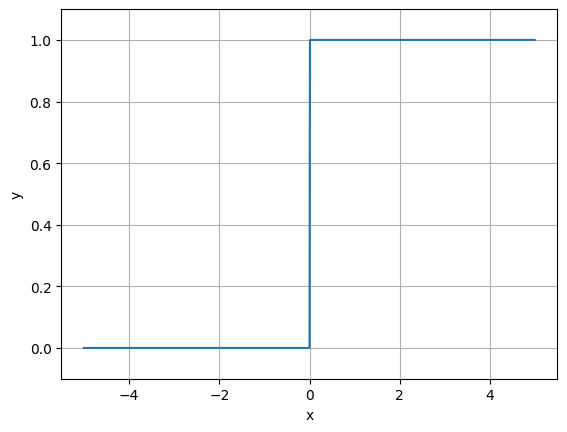

In [28]:
x = np.arange(-5.0, 5.0, 0.01)
y = step_function(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(SAVE_PATH / "step_function.png")

### 임곗값 함수

In [30]:
def threshold_function(x, threshold=0.0):
  y = x.copy()
  y[y < threshold] = -1.0
  return y

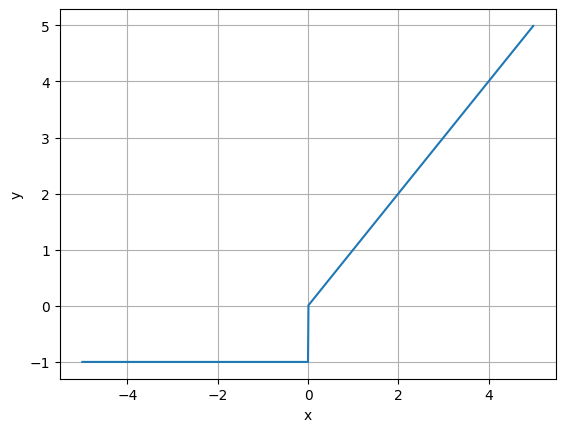

In [32]:
x = np.arange(-5.0, 5.0, 0.01)
y = threshold_function(x)
plt.plot(x, y)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(SAVE_PATH / "threshold_function.png")

### 하이퍼볼릭 탄젠트 함수

In [33]:
def tanh_function(x):
  return np.tanh(x)

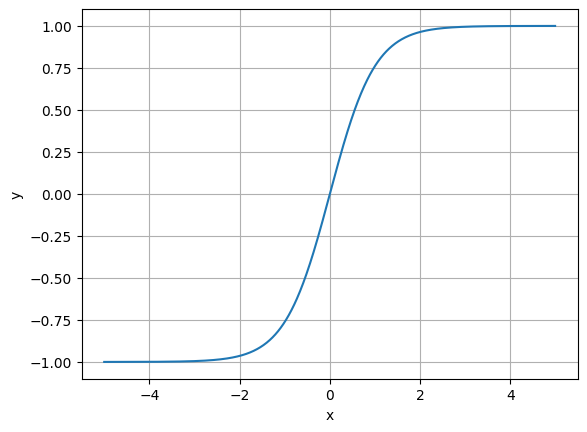

In [34]:
x = np.arange(-5.0, 5.0, 0.01)
y = tanh_function(x)
plt.plot(x, y)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(SAVE_PATH / "tanh_function.png")

### ReLU

In [35]:
def relu_function(x):
  return np.maximum(0, x)

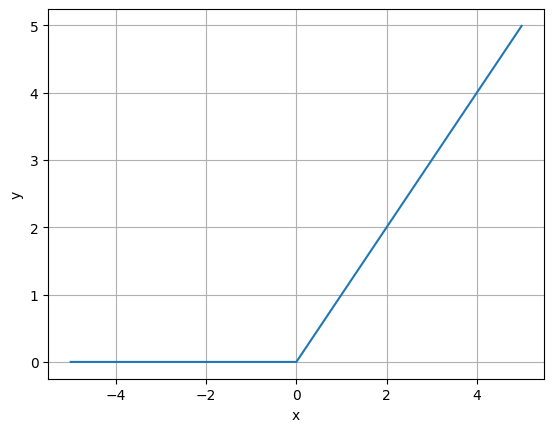

In [36]:
x = np.arange(-5.0, 5.0, 0.01)
y = relu_function(x)
plt.plot(x, y)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(SAVE_PATH / "relu_function.png")

### LeakyReLU

In [39]:
def leaky_relu_function(x, alpha=0.1):
  return np.maximum(alpha * x, x)

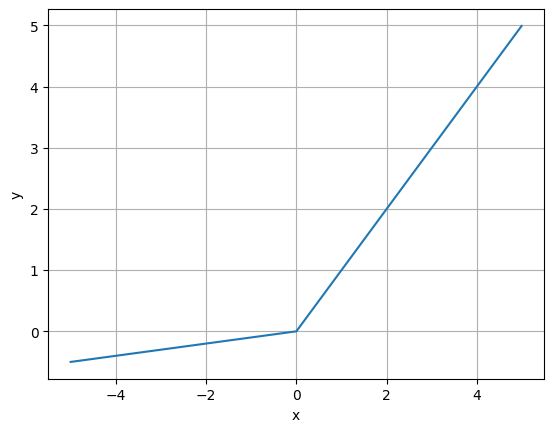

In [40]:
x = np.arange(-5.0, 5.0, 0.01)
y = leaky_relu_function(x)
plt.plot(x, y)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(SAVE_PATH / "leaky_relu_function.png")

### ELU

In [48]:
def elu_function(x, alpha=0.2):
  return np.where(x > 0, x, alpha * (np.exp(x) - 1))

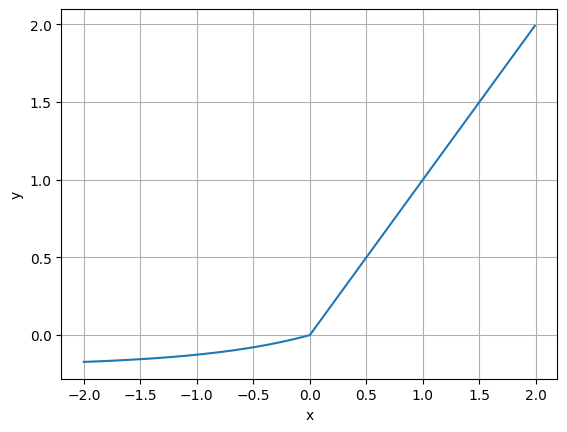

In [51]:
x = np.arange(-2.0, 2.0, 0.01)
y = elu_function(x)
plt.plot(x, y)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(SAVE_PATH / "elu_function.png")

### 소프트맥스 함수

In [52]:
def softmax_function(x):
  return np.exp(x) / np.sum(np.exp(x))

In [54]:
x = np.arange(-2.0, 2.0, 0.01)
y = softmax_function(x)
print(y.sum())

1.0
